# Data overview

This is just a **quick overview** of the dataset.

In [1]:
import os
import re
import copy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS_SET
from spacy.symbols import ORTH, LEMMA, POS

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Reshape, Bidirectional, concatenate, Flatten
from keras_contrib.layers import CRF
from keras_contrib.metrics import crf_accuracy
from keras_contrib.losses import crf_loss
from keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence

from collections import Counter

Using TensorFlow backend.


In [2]:
DATA_PATH = '../data/'

train_file = 'NCBI_corpus_training.txt'
test_file = 'NCBI_corpus_testing.txt'

with open(DATA_PATH + train_file, 'r') as fp:
    train_dataset = fp.readlines()

with open(DATA_PATH + test_file, 'r') as fp:
    test_dataset = fp.readlines()

print('Train texts: %d' % len(train_dataset))
print('Test texts: %d' % len(test_dataset))

Train texts: 593
Test texts: 100


In [3]:
ENTITY_START = '<entity>'
ENTITY_END = '</entity>'

MAX_SEQUENCE_LENGTH = 100
MODEL_NAME = 'ner-lstm-crf'

UNK = '<UNK>'

## Prepare data

This is a minimal preprocess of the data, as I do not want to remove any essential information from texts.

The dataset that I am using contains a number in the beginning of every text, thus I need to remove that number. Also, I replace the `category` tags with `<entity>`, so I can add them to the vocabular of Spacy.

In [4]:
def apply_initial_cleaner(texts):
    texts = [re.sub(r'^[0-9]+\s*', '', text) for text in texts]
    texts = [re.sub(r'<category=".+?">(.+?)</category>', r'{}\1{}'.format(ENTITY_START, ENTITY_END), text) for text in texts]
    return texts

In [5]:
train_dataset = apply_initial_cleaner(train_dataset)
test_dataset = apply_initial_cleaner(test_dataset)

print(train_dataset[0]) # Sample

Identification of APC2, a homologue of the <entity>adenomatous polyposis coli tumour</entity> suppressor .	The <entity>adenomatous polyposis coli ( APC ) tumour</entity>-suppressor protein controls the Wnt signalling pathway by forming a complex with glycogen synthase kinase 3beta ( GSK-3beta ) , axin / conductin and betacatenin . Complex formation induces the rapid degradation of betacatenin . In <entity>colon carcinoma</entity> cells , loss of APC leads to the accumulation of betacatenin in the nucleus , where it binds to and activates the Tcf-4 transcription factor ( reviewed in [ 1 ] [ 2 ] ) . Here , we report the identification and genomic structure of APC homologues . Mammalian APC2 , which closely resembles APC in overall domain structure , was functionally analyzed and shown to contain two SAMP domains , both of which are required for binding to conductin . Like APC , APC2 regulates the formation of active betacatenin-Tcf complexes , as demonstrated using transient transcriptio

I split the texts using the **Spacy Tokenizer**. Note that I split not only the words but also the sentences, so I consider each sentence as an independent input of the model.

In [6]:
def get_nlp_engine():
    nlp = spacy.load('en_core_web_sm')
    
    nlp.tokenizer.add_special_case(ENTITY_START, [{ORTH: ENTITY_START, LEMMA: u'<entity>', POS: u'X'}])
    nlp.tokenizer.add_special_case(ENTITY_END, [{ORTH: ENTITY_END, LEMMA: u'</entity>', POS: u'X'}])
    
    return nlp

In [7]:
def get_tokens(nlp_tokens):
    pos = [w.pos_ for w in nlp_tokens]
    words = [w.lemma_.strip() if w.lemma_ != "-PRON-" else w.lower_.strip() for w in nlp_tokens]
    tokens = [(words[i].lower(), pos[i], nlp_tokens[i]) for i in range(len(nlp_tokens))]
        
    # Remove empty tokens
    tokens = [token for token in tokens if token[0].strip() != '']

    return tokens

In [8]:
def tokenize_texts(dataset, split_sentences=True):
    tok_dataset = []
    
    nlp = get_nlp_engine()
    
    for index, text in enumerate(dataset):
        text = re.sub(rf'({ENTITY_START}|{ENTITY_END})', r' \1 ', text, re.UNICODE)
        text = re.sub(r"\s+", ' ', text.strip())  # Normalize white spaces
        nlp_tokens = nlp(text)
        
        if split_sentences:
            sentences = []
            
            entity_indicator = 0
            sentence_stack = []
            
            for s in nlp_tokens.sents:
                for token in s:
                    if token.text == ENTITY_START:
                        entity_indicator = entity_indicator + 1
                    elif token.text == ENTITY_END:
                        entity_indicator = entity_indicator - 1
                
                sentence_stack = sentence_stack + list(s)
                if entity_indicator == 0:
                    sentences.append(sentence_stack)
                    sentence_stack = []
            
            for s in sentences:
                tokens = get_tokens(s)
                tok_dataset.append(tokens)
        else:
            tokens = get_tokens(nlp_tokens)
            tok_dataset.append(tokens)
    
    return np.array(tok_dataset)

In [9]:
tok_train_dataset = tokenize_texts(train_dataset)
tok_test_dataset = tokenize_texts(test_dataset)

print(tok_train_dataset[0]) # Sample

[('identification', 'NOUN', Identification), ('of', 'ADP', of), ('apc2', 'PROPN', APC2), (',', 'PUNCT', ,), ('a', 'DET', a), ('homologue', 'NOUN', homologue), ('of', 'ADP', of), ('the', 'DET', the), ('<entity>', 'X', <entity>), ('adenomatous', 'ADJ', adenomatous), ('polyposis', 'NOUN', polyposis), ('coli', 'NOUN', coli), ('tumour', 'NOUN', tumour), ('</entity>', 'X', </entity>), ('suppressor', 'NOUN', suppressor), ('.', 'PUNCT', .)]


In [12]:
def get_texts_words(tok_dataset, skip_entity_tags=True):
    if skip_entity_tags:
        skip_tokens = [ENTITY_START, ENTITY_END]
    else:
        skip_tokens = []
    
    texts_words = [[token[0] for token in text if token[0] not in skip_tokens] for text in tok_dataset]
    return np.array(texts_words)

In [13]:
train_words = get_texts_words(tok_train_dataset)
test_words = get_texts_words(tok_test_dataset)

print(train_words[0]) # Sample

['identification', 'of', 'apc2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.']


In [16]:
def get_vocab_dictionary(data_words, additional_words=[], num_words=150000, min_count=1):
    counter_words = Counter()
    for words in data_words:
        counter_words.update(words)

    vocab_words_count = {w for w, c in counter_words.items() if c >= min_count}
    vocab_words = sorted(list(vocab_words_count))
    
    vocab_words = [''] + list(additional_words) + vocab_words
    if len(vocab_words) - 1 > num_words:
        vocab_words = vocab_words[1:(num_words + 1)]
    
    word2id = {word.strip(): idx for idx, word in enumerate(vocab_words)}
    
    del word2id['']
    del vocab_words[0]
    
    vocab_size = len(vocab_words)
    
    return vocab_words, word2id, vocab_size

In [18]:
additional = [UNK]

vocab_words, word2id, vocab_words_size = get_vocab_dictionary(train_words, additional)

In [20]:
print('Vocabulary size: %d' % vocab_words_size)

Vocabulary size: 7791


A **quick plot** of the data shows up that almost all sentences are less than $50$ tokens in length.

In [22]:
full_words = list(train_words) + list(test_words)

<function matplotlib.pyplot.show(*args, **kw)>

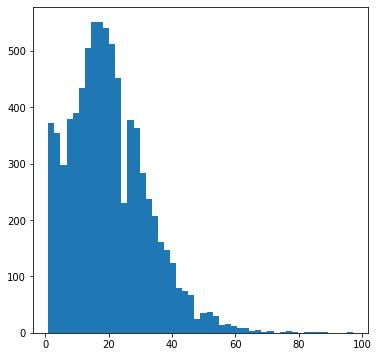

In [23]:
plt.figure(figsize=(6, 6))
plt.hist([len(s) for s in full_words], bins=50)
plt.show